In [50]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pandas as pd
import glob
import os
import cv2
import random as rand
import time
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
from PIL import Image
from mtcnn.mtcnn import MTCNN
import insightface
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### Defining some test images..

In [65]:
test_img = glob.glob('../test images/*.[jJ][Pp][Gg]')

In [4]:
def exec_time(start, end):
    diff_time = end - start
    return diff_time

### Testing on different crowd sizes with Face Detection and Face Mask Classifier

Note that for comparison purposes, we selected face detection parameters based on default parameters.

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


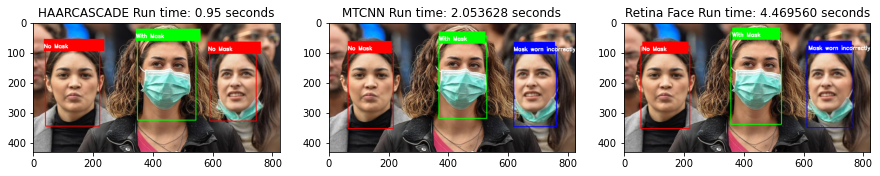

In [88]:
fig, axes = plt.subplots(1,3, figsize=(15,15))
warnings.filterwarnings("ignore")
for mod, i  in zip(['haar','mtcnn','retina'], [0,1,2]):
    predict(test_img[2],mod, axes[i])

In terms of speed, haar cascade is the fastest. But has some bounding box issues which leads to model in accuracies.

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


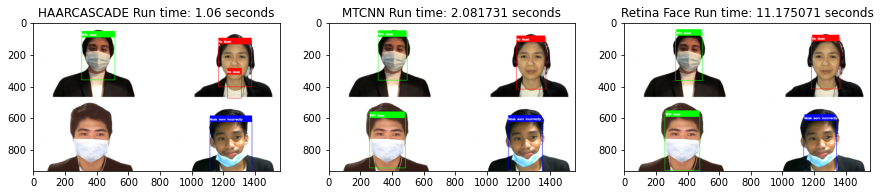

In [72]:
fig, axes = plt.subplots(1,3, figsize=(15,15))
warnings.filterwarnings("ignore")
for mod, i  in zip(['haar','mtcnn','retina'], [0,1,2]):
    predict(test_img[8],mod, axes[i])

Comparing the three models, haar cascade also did poorly in identifying the face. MTCNN and retina face did well. 

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


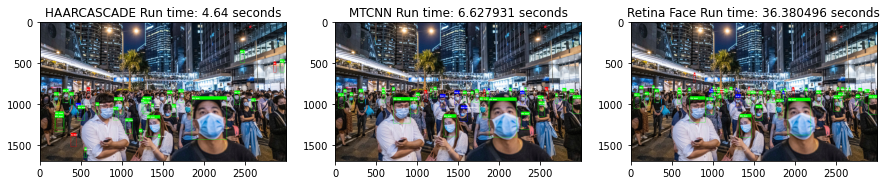

In [74]:
fig, axes = plt.subplots(1,3, figsize=(15,15))
warnings.filterwarnings("ignore")
for mod, i  in zip(['haar','mtcnn','retina'], [0,1,2]):
    predict(test_img[0],mod, axes[i])

In terms of large crowds, HAAR cascade also works very poorly with only a few faces detected. The threshold can be adjusted but takes too much time. MTCNN and Retina face did well but Retina Face detected more faces It is however extremely slow compared to MTCNN. 

MTCNN is a good balance between speed and accuracy in terms of face detection.

In [87]:
def predict(image, model, ax):
    """Detects faces in an input image and Predicts Class."""
    img = plt.imread(image)
    
    color_dict = {2: (255, 0, 0), 1: (0, 255, 0), 0: (0, 0, 255)}
    labels_dict = {0: 'Mask worn incorrectly', 1: 'With Mask', 2: 'No Mask'}
    masknet = load_model('../models/facemask_det_v1.h5')
    
    if model == 'retina':
        retinaface = insightface.model_zoo.get_model('retinaface_r50_v1')
        retinaface.prepare(ctx_id = -1, nms=0.4);
        start = time.time()
        bbox, landmark = retinaface.detect(img)
        for box in bbox:
            (x,y,w,h,z) = box.tolist()
            try:
                x, y, w, h = int(x), int(y), int(w), int(h)
                face_img = img[int(y - 35):int(h+70), x-5:w+5]
                resized = cv2.resize(face_img, (108, 108))
                normalized = resized/255.0
                reshaped = np.reshape(normalized, (-1, 108, 108, 3))
                reshaped = np.vstack([reshaped])
                result = masknet.predict(reshaped)
                label = np.argmax(result, axis=1)[0]
                
                cv2.rectangle(img, (x-5, y-25), (w+5, h+60),
                              color_dict[label], 2)
                cv2.rectangle(img, (x, y-40), (w, y),
                              color_dict[label], -1)
                cv2.putText(img, labels_dict[label], (x, y-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

            except:
                continue
        end = time.time()
        ax.set_title(f'Retina Face Run time: {exec_time(start, end):2f} seconds')
        ax.imshow(img)

    elif model == 'haar':
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 
                                             'haarcascade_frontalface_default.xml')
        start = time.time()
        faces = face_cascade.detectMultiScale(img)
        for (x, y, w, h) in faces:
            face_img = img[int(y - 5):int(y+h+50), x+5:x+w-15]
            resized = cv2.resize(face_img, (108, 108))
            normalized = resized/255.0
            reshaped = np.reshape(normalized, (-1, 108, 108, 3))
            reshaped = np.vstack([reshaped])
            result = masknet.predict(reshaped)

            label = np.argmax(result, axis=1)[0]
            cv2.rectangle(img, (x+5, y-5), (x+w-15, y+h+50),
                          color_dict[label], 2)
            cv2.rectangle(img, (x, y-40), (x+w, y),
                          color_dict[label], -1)
            cv2.putText(img, labels_dict[label], (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        end = time.time()
        ax.set_title(f'HAARCASCADE Run time: {exec_time(start, end):.2f} seconds')
        ax.imshow(img)

    elif model == 'mtcnn':
        detector = MTCNN()
        start = time.time()
        faces = detector.detect_faces(img)
        for f in faces:
            (x, y, w, h) = f['box']
            try:
                face_img = img[int(y - 20):int(y+h+50), x-5:x+w+5]
                resized = cv2.resize(face_img, (108, 108))
                normalized = resized/255.0
                reshaped = np.reshape(normalized, (-1, 108, 108, 3))
                reshaped = np.vstack([reshaped])
                result = masknet.predict(reshaped)
                label = np.argmax(result, axis=1)[0]
                
                cv2.rectangle(img, (x, y-25), (x+w+5, y+h+60),
                          color_dict[label], 2)
                cv2.rectangle(img, (x, y-40), (x+w, y),
                          color_dict[label], -1)
                cv2.putText(img, labels_dict[label], (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

            except:
                continue
        end = time.time()
        ax.set_title(f'MTCNN Run time: {exec_time(start, end):2f} seconds')
        ax.imshow(img)